<h1 id="title"><center>Code for Predicting Motor Vehicle Accident Severity in Seattle, Washington</center></h1>
<h2 id="author"><center>Christopher Bates</center></h2>
<h3 id="data"><center>12 December 2020</center></h3>

This notebook contains the Python code for the Applied Data Science Capstone Project.
In this project, we use a publicly available data set to build several kinds of supervised learning models to predict the severity of motor vehicle accidents in Seattle, Washington.

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.tree import plot_tree
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7f8f9b3444c0>


In [7]:
# Set the sampling ratio (percentage of minority class to (over)sample).
sampling_ratio = 20

# Set test ratio (percentage of data set to use as test data),and number of folds.
test_size_ratio = .2

# Set the number of folds for cross-validation.
number_of_folds = 5

# Set an upper bound for the number of neighbors.
neighbors_upper_bound = 50

In [8]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [9]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [10]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [12]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.433297518000472 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [13]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown" or "other",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
    {"EXCEPTRSNCODE": " ",\
     "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
     "COLLISIONTYPE": "Other",\
     "SEVERITYCODE": "0",\
     "SEVERITYDESC": "Unknown",\
     "JUNCTIONTYPE": "Unknown",\
     "WEATHER": "Unknown",\
     "ROADCOND": "Unknown",\
     "LIGHTCOND": "Unknown",\
     "SDOT_COLCODE": float(0),\
     "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
     "ST_COLCODE": " ",\
     "ST_COLDESC": "Not stated"}, value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace=\
    {"ST_COLCODE": "0",\
     "WEATHER": "Other",\
     "ROADCOND": "Other",\
     "LIGHTCOND": "Other"}, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace=\
    {"LIGHTCOND": "Dark - Unknown Lighting"}, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [14]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.83761514897924 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [15]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [16]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "PERSONCOUNT",\
                           "VEHCOUNT",\
                           "INJURIES",\
                           "SERIOUSINJURIES",\
                           "FATALITIES",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [17]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [18]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [19]:
minor_severity_labels = ['1', '2']
major_severity_labels = ['2b', '3']

In [20]:
series_is_severe = df_drop_columns_and_rows['SEVERITYCODE'].isin(major_severity_labels)

In [21]:
series_is_severe.value_counts()

False    146635
True       2696
Name: SEVERITYCODE, Length: 2, dtype: int64

In [22]:
# Define a new column called 'IS_SEVERE'.
# For each row of the DataFrame, if 'SEVERITYCODE' is '2b' or '3', then 'IS_SEVERE' gets the boolean value of True.
# If 'SEVERITYCODE' is '1' or '2', then 'IS_SEVERE' gets the boolean value of False.
df_drop_columns_and_rows.insert(0, 'IS_SEVERE', series_is_severe)

In [23]:
# Drop column SEVERITYCODE from DataFrame in place, because severity is now represented by column IS_SEVERE.
df_drop_columns_and_rows = df_drop_columns_and_rows.drop(columns=['SEVERITYCODE'], inplace=False)

In [24]:
df_drop_columns_and_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149331 entries, 0 to 221388
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   IS_SEVERE      149331 non-null  bool   
 1   X              149331 non-null  float64
 2   Y              149331 non-null  float64
 3   COLLISIONTYPE  149331 non-null  object 
 4   PEDCOUNT       149331 non-null  int64  
 5   PEDCYLCOUNT    149331 non-null  int64  
 6   WEATHER        149331 non-null  object 
 7   ROADCOND       149331 non-null  object 
 8   LIGHTCOND      149331 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(4)
memory usage: 10.4+ MB


In [25]:
df_drop_columns_and_rows.head()

,IS_SEVERE,X,Y,COLLISIONTYPE,PEDCOUNT,PEDCYLCOUNT,WEATHER,ROADCOND,LIGHTCOND
0,False,-122.320757054,47.609407946,Sideswipe,0,0,Raining,Wet,Dark - Street Lights On
1,False,-122.319560827,47.662220664,Parked Car,0,0,Clear,Dry,Daylight
5,False,-122.374193726,47.564075600,Rear Ended,0,0,Clear,Dry,Daylight
8,False,-122.336564829,47.590397830,Sideswipe,0,0,Overcast,Dry,Daylight
9,False,-122.329048658,47.593341161,Sideswipe,0,0,Clear,Dry,Daylight


In [26]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.07529179600533 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [27]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [28]:
# Create DataFrame of categorical or integer columns, inclusive.
df_categorical = df_converted.select_dtypes(include=['bool', 'category', 'integer'])

In [29]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.564021396974567 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [30]:
df_categorical.head()

,IS_SEVERE,COLLISIONTYPE,PEDCOUNT,PEDCYLCOUNT,WEATHER,ROADCOND,LIGHTCOND
0,False,Sideswipe,0,0,Raining,Wet,Dark - Street Lights On
1,False,Parked Car,0,0,Clear,Dry,Daylight
5,False,Rear Ended,0,0,Clear,Dry,Daylight
8,False,Sideswipe,0,0,Overcast,Dry,Daylight
9,False,Sideswipe,0,0,Clear,Dry,Daylight


In [31]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149331 entries, 0 to 221388
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   IS_SEVERE      149331 non-null  bool    
 1   COLLISIONTYPE  149331 non-null  category
 2   PEDCOUNT       149331 non-null  int64   
 3   PEDCYLCOUNT    149331 non-null  int64   
 4   WEATHER        149331 non-null  category
 5   ROADCOND       149331 non-null  category
 6   LIGHTCOND      149331 non-null  category
dtypes: bool(1), category(4), int64(2)
memory usage: 4.1 MB


In [32]:
# Severity vs. Collision Type

In [33]:
print('IS_SEVERE Relative Frequencies:\n')
df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False)

IS_SEVERE Relative Frequencies:



False   0.981946146
True    0.018053854
Name: IS_SEVERE, Length: 2, dtype: float64

In [34]:
print('IS_SEVERE Value Counts:\n')
df_categorical['IS_SEVERE'].value_counts(normalize=False, dropna=False)

IS_SEVERE Value Counts:



False    146635
True       2696
Name: IS_SEVERE, Length: 2, dtype: int64

In [35]:
len(df_categorical)

149331

In [36]:
# For each class of COLLISIONTYPE, get the relative frequencies for IS_SEVERE, i.e.
# for each COLLISIONTYPE group, compute the number of rows with IS_SEVERE=True divided by the size of the this COLLISIONTYPE group.

# Create a GroupBy object on COLLISIONTYPE.
groupby_collisiontype = df_categorical[['COLLISIONTYPE', 'IS_SEVERE']].groupby(by=['COLLISIONTYPE'])

# Create a GroupBy object on COLLISIONTYPE, IS_SEVERE.
groupby_collisiontype_is_severe = df_categorical[['COLLISIONTYPE', 'IS_SEVERE']].groupby(by=['COLLISIONTYPE', 'IS_SEVERE'])

print('IS_SEVERE relative frequencies:')
print(df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False))
print()

df_value_counts_by_collisiontype = pd.DataFrame(data=groupby_collisiontype_is_severe.size(), columns=['Value Counts'])
print('IS_SEVERE value counts over each COLLISIONTYPE group:\n', df_value_counts_by_collisiontype)
print()

severity_frequency_cutoff = df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False).min()
print('Proportion of all data with IS_SEVERE=True: %f' % (severity_frequency_cutoff))
print()

df_frequencies_by_collisiontype = pd.DataFrame(data=groupby_collisiontype_is_severe.size() / groupby_collisiontype.size(),\
                                               columns=['Relative Frequencies'])
print('IS_SEVERE relative frequencies normalized over each COLLISIONTYPE group:\n', df_frequencies_by_collisiontype)
print()

print('IS_SEVERE relative frequencies normalized over each COLLISIONTYPE group,\n',\
      'given the proportion of IS_SEVERE=True > %f:\n' % (severity_frequency_cutoff),\
      df_frequencies_by_collisiontype[df_frequencies_by_collisiontype.xs(True, level=1, axis=0) > severity_frequency_cutoff].dropna(), sep='')

IS_SEVERE relative frequencies:
False   0.981946146
True    0.018053854
Name: IS_SEVERE, Length: 2, dtype: float64

IS_SEVERE value counts over each COLLISIONTYPE group:
                          Value Counts
COLLISIONTYPE IS_SEVERE              
Angles        False             34017
              True                466
Cycles        False              5250
              True                428
Head On       False              1962
              True                117
Left Turn     False             13401
              True                283
Parked Car    False             33570
              True                133
Pedestrian    False              6344
              True                943
Rear Ended    False             31972
              True                225
Right Turn    False              2817
              True                 21
Sideswipe     False             17302
              True                 80

[18 rows x 1 columns]

Proportion of all data with IS_SEVERE=True: 0

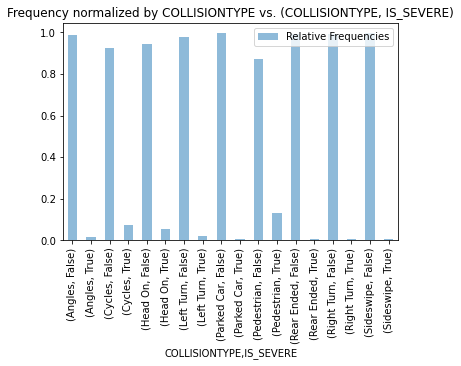

In [37]:
ax = df_frequencies_by_collisiontype.plot.bar(alpha=.5, title='Frequency normalized by COLLISIONTYPE vs. (COLLISIONTYPE, IS_SEVERE)')

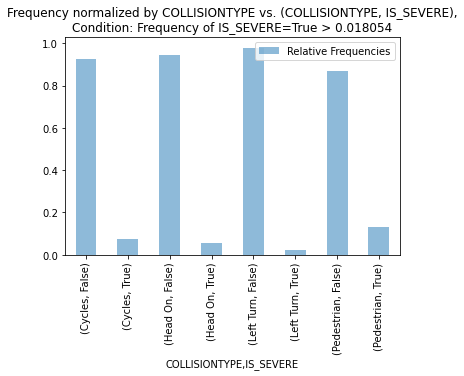

In [38]:
ax = df_frequencies_by_collisiontype[
    df_frequencies_by_collisiontype.xs(True, level=1, axis=0) > severity_frequency_cutoff]\
    .dropna().plot.bar(alpha=.5,\
    title='Frequency normalized by COLLISIONTYPE vs. (COLLISIONTYPE, IS_SEVERE),\nCondition: Frequency of IS_SEVERE=True > %f' %\
    (severity_frequency_cutoff))

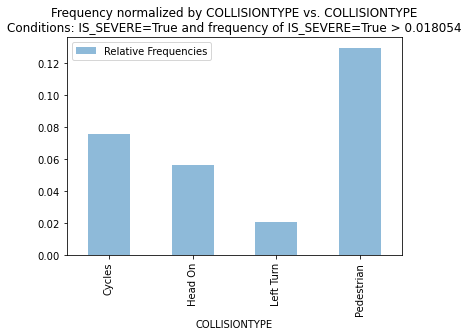

In [39]:
ax = df_frequencies_by_collisiontype[\
    df_frequencies_by_collisiontype.xs(True, level=1, axis=0) > severity_frequency_cutoff]\
    .dropna().xs(True, level=1, axis=0).plot.bar(alpha=.5,\
    title='Frequency normalized by COLLISIONTYPE vs. COLLISIONTYPE\nConditions: IS_SEVERE=True and frequency of IS_SEVERE=True > %f' %\
    (severity_frequency_cutoff))

In [40]:
print('IS_SEVERE Relative Frequencies:\n')
df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False)

IS_SEVERE Relative Frequencies:



False   0.981946146
True    0.018053854
Name: IS_SEVERE, Length: 2, dtype: float64

In [41]:
print('IS_SEVERE Value Counts:\n')
df_categorical['IS_SEVERE'].value_counts(normalize=False, dropna=False)

IS_SEVERE Value Counts:



False    146635
True       2696
Name: IS_SEVERE, Length: 2, dtype: int64

In [42]:
len(df_categorical)

149331

In [43]:
# For each class of WEATHER, get the relative frequencies for IS_SEVERE, i.e.
# for each weather group, compute the number of rows with IS_SEVERE=True divided by the size of the this weather group.

# Create a GroupBy object on WEATHER.
groupby_weather = df_categorical[['WEATHER', 'IS_SEVERE']].groupby(by=['WEATHER'])

# Create a GroupBy object on WEATHER, IS_SEVERE.
groupby_weather_is_severe = df_categorical[['WEATHER', 'IS_SEVERE']].groupby(by=['WEATHER', 'IS_SEVERE'])

# Create a multiindexed DataFrame.
#df_grouped_by_weather_severity = pd.DataFrame(df_categorical[['WEATHER', 'IS_SEVERE']].groupby(by=['WEATHER', 'IS_SEVERE']).count())
#print(df_grouped_by_weather_severity.head())
#print()

print('IS_SEVERE relative frequencies:')
print(df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False))
print()

df_value_counts_by_weather = pd.DataFrame(data=groupby_weather_is_severe.size(), columns=['Value Counts'])
print('IS_SEVERE value counts for each WEATHER class:\n', df_value_counts_by_weather)
print()

severity_frequency_cutoff = df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False).min()
print('Proportion of all data with IS_SEVERE=True: %f' % (severity_frequency_cutoff))
print()

df_frequencies_by_weather = pd.DataFrame(data=groupby_weather_is_severe.size() / groupby_weather.size(), columns=['Relative Frequencies'])
print('IS_SEVERE relative frequencies normalized by WEATHER class:\n', df_frequencies_by_weather)
print()

print('IS_SEVERE relative frequencies normalized by WEATHER class,\n',\
      'given the proportion of IS_SEVERE=True > %f:\n' % (severity_frequency_cutoff),\
      df_frequencies_by_weather[df_frequencies_by_weather.xs(True, level=1, axis=0) > severity_frequency_cutoff].dropna(), sep='')
print()

IS_SEVERE relative frequencies:
False   0.981946146
True    0.018053854
Name: IS_SEVERE, Length: 2, dtype: float64

IS_SEVERE value counts for each WEATHER class:
                                     Value Counts
WEATHER                  IS_SEVERE              
Blowing Sand/Dirt        False                39
                         True                  0
Clear                    False             95319
                         True               1815
Fog/Smog/Smoke           False               424
                         True                  3
Overcast                 False             23033
                         True                393
Partly Cloudy            False                 7
                         True                  0
Raining                  False             27087
                         True                475
Severe Crosswind         False                15
                         True                  1
Sleet/Hail/Freezing Rain False                80
   

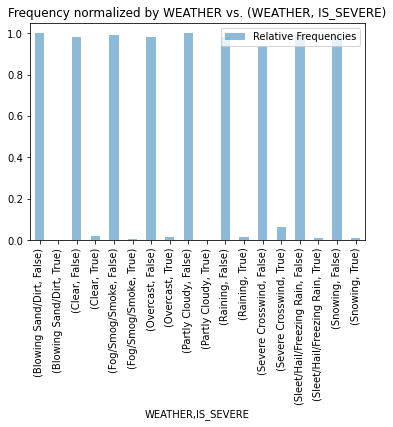

In [44]:
ax = df_frequencies_by_weather.plot.bar(alpha=.5, title='Frequency normalized by WEATHER vs. (WEATHER, IS_SEVERE)')

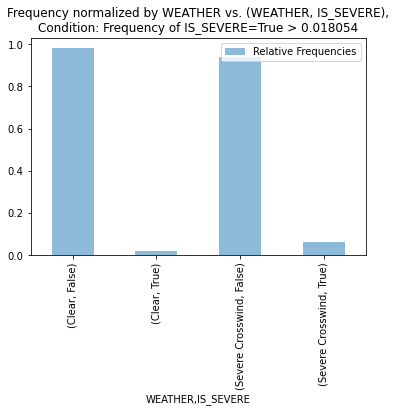

In [45]:
ax = df_frequencies_by_weather[df_frequencies_by_weather.xs(True, level=1, axis=0) > severity_frequency_cutoff].dropna().plot.bar(alpha=.5,\
    title='Frequency normalized by WEATHER vs. (WEATHER, IS_SEVERE),\nCondition: Frequency of IS_SEVERE=True > %f' %
    (severity_frequency_cutoff))

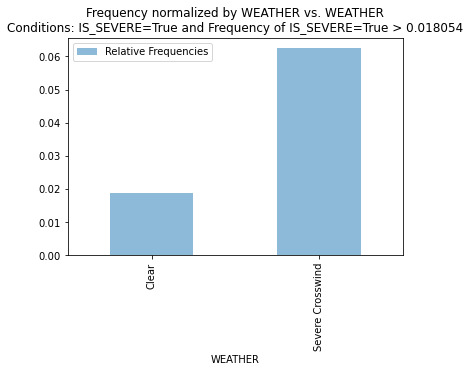

In [46]:
ax = df_frequencies_by_weather[\
    df_frequencies_by_weather.xs(True, level=1, axis=0) > severity_frequency_cutoff]\
    .dropna().xs(True, level=1, axis=0).plot.bar(alpha=.5,\
    title='Frequency normalized by WEATHER vs. WEATHER\nConditions: IS_SEVERE=True and Frequency of IS_SEVERE=True > %f' %\
    (severity_frequency_cutoff))

In [47]:
# Severity vs. Road Conditions

In [48]:
print('IS_SEVERE Relative Frequencies:\n')
df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False)

IS_SEVERE Relative Frequencies:



False   0.981946146
True    0.018053854
Name: IS_SEVERE, Length: 2, dtype: float64

In [49]:
print('IS_SEVERE Value Counts:\n')
df_categorical['IS_SEVERE'].value_counts(normalize=False, dropna=False)

IS_SEVERE Value Counts:



False    146635
True       2696
Name: IS_SEVERE, Length: 2, dtype: int64

In [50]:
len(df_categorical)

149331

In [51]:
# For each class of ROADCOND, get the relative frequencies for IS_SEVERE, i.e.
# for each ROADCOND group, compute the number of rows with IS_SEVERE=True divided by the size of the this ROADCOND group.

# Create a GroupBy object on ROADCOND.
groupby_roadcond = df_categorical[['ROADCOND', 'IS_SEVERE']].groupby(by=['ROADCOND'])

# Create a GroupBy object on ROADCOND, IS_SEVERE.
groupby_roadcond_is_severe = df_categorical[['ROADCOND', 'IS_SEVERE']].groupby(by=['ROADCOND', 'IS_SEVERE'])

print('IS_SEVERE relative frequencies:')
print(df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False))
print()

df_value_counts_by_roadcond = pd.DataFrame(data=groupby_roadcond_is_severe.size(), columns=['Value Counts'])
print('IS_SEVERE value counts over each ROADCOND group:\n', df_value_counts_by_roadcond)
print()

severity_frequency_cutoff = df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False).min()
print('Proportion of all data with IS_SEVERE=True: %f' % (severity_frequency_cutoff))
print()

df_frequencies_by_roadcond = pd.DataFrame(data=groupby_roadcond_is_severe.size() / groupby_roadcond.size(), columns=['Relative Frequencies'])
print('IS_SEVERE relative frequencies normalized over each ROADCOND group:\n', df_frequencies_by_roadcond)
print()

print('IS_SEVERE relative frequencies normalized over each ROADCOND group,\n',\
      'given the proportion of IS_SEVERE=True > %f:\n' % (severity_frequency_cutoff),\
      df_frequencies_by_roadcond[df_frequencies_by_roadcond.xs(True, level=1, axis=0) > severity_frequency_cutoff].dropna(), sep='')

IS_SEVERE relative frequencies:
False   0.981946146
True    0.018053854
Name: IS_SEVERE, Length: 2, dtype: float64

IS_SEVERE value counts over each ROADCOND group:
                           Value Counts
ROADCOND       IS_SEVERE              
Dry            False            106607
               True               2025
Ice            False               689
               True                  9
Oil            False                21
               True                  0
Sand/Mud/Dirt  False                30
               True                  0
Snow/Slush     False               634
               True                  6
Standing Water False                50
               True                  1
Wet            False             38604
               True                655

[14 rows x 1 columns]

Proportion of all data with IS_SEVERE=True: 0.018054

IS_SEVERE relative frequencies normalized over each ROADCOND group:
                           Relative Frequencies
ROADCOND       I

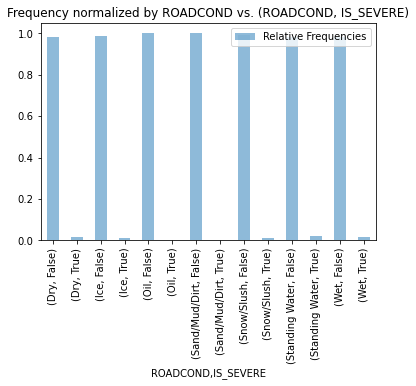

In [52]:
ax = df_frequencies_by_roadcond.plot.bar(alpha=.5, title='Frequency normalized by ROADCOND vs. (ROADCOND, IS_SEVERE)')

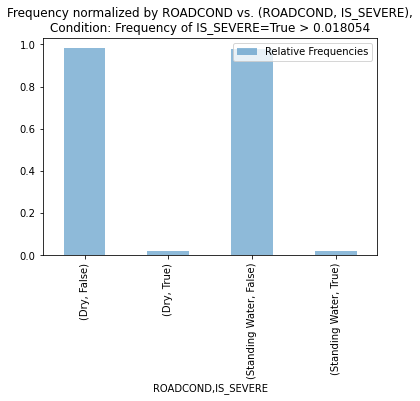

In [53]:
ax = df_frequencies_by_roadcond[df_frequencies_by_roadcond.xs(True, level=1, axis=0) > severity_frequency_cutoff].dropna().plot.bar(alpha=.5,\
    title='Frequency normalized by ROADCOND vs. (ROADCOND, IS_SEVERE),\nCondition: Frequency of IS_SEVERE=True > %f' %
    (severity_frequency_cutoff))

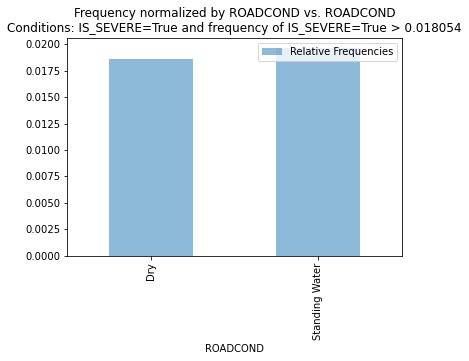

In [54]:
ax = df_frequencies_by_roadcond[\
    df_frequencies_by_roadcond.xs(True, level=1, axis=0) > severity_frequency_cutoff]\
    .dropna().xs(True, level=1, axis=0).plot.bar(alpha=.5,\
    title='Frequency normalized by ROADCOND vs. ROADCOND\nConditions: IS_SEVERE=True and frequency of IS_SEVERE=True > %f' %\
    (severity_frequency_cutoff))

In [55]:
# Severity vs. Light Conditions

In [56]:
print('IS_SEVERE Relative Frequencies:\n')
df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False)

IS_SEVERE Relative Frequencies:



False   0.981946146
True    0.018053854
Name: IS_SEVERE, Length: 2, dtype: float64

In [57]:
print('IS_SEVERE Value Counts:\n')
df_categorical['IS_SEVERE'].value_counts(normalize=False, dropna=False)

IS_SEVERE Value Counts:



False    146635
True       2696
Name: IS_SEVERE, Length: 2, dtype: int64

In [58]:
len(df_categorical)

149331

In [59]:
# For each class of LIGHTCOND, get the relative frequencies for IS_SEVERE, i.e.
# for each LIGHTCOND group, compute the number of rows with IS_SEVERE=True divided by the size of the this LIGHTCOND group.

# Create a GroupBy object on LIGHTCOND.
groupby_lightcond = df_categorical[['LIGHTCOND', 'IS_SEVERE']].groupby(by=['LIGHTCOND'])

# Create a GroupBy object on LIGHTCOND, IS_SEVERE.
groupby_lightcond_is_severe = df_categorical[['LIGHTCOND', 'IS_SEVERE']].groupby(by=['LIGHTCOND', 'IS_SEVERE'])

print('IS_SEVERE relative frequencies:')
print(df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False))
print()

df_value_counts_by_lightcond = pd.DataFrame(data=groupby_lightcond_is_severe.size(), columns=['Value Counts'])
print('IS_SEVERE value counts over each LIGHTCOND group:\n', df_value_counts_by_lightcond)
print()

severity_frequency_cutoff = df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False).min()
print('Proportion of all data with IS_SEVERE=True: %f' % (severity_frequency_cutoff))
print()

df_frequencies_by_lightcond = pd.DataFrame(data=groupby_lightcond_is_severe.size() / groupby_lightcond.size(), columns=['Relative Frequencies'])
print('IS_SEVERE relative frequencies normalized over each LIGHTCOND group:\n', df_frequencies_by_lightcond)
print()

print('IS_SEVERE relative frequencies normalized over each LIGHTCOND group,\n',\
      'given the proportion of IS_SEVERE=True > %f:\n' % (severity_frequency_cutoff),\
      df_frequencies_by_lightcond[df_frequencies_by_lightcond.xs(True, level=1, axis=0) > severity_frequency_cutoff].dropna(), sep='')

IS_SEVERE relative frequencies:
False   0.981946146
True    0.018053854
Name: IS_SEVERE, Length: 2, dtype: float64

IS_SEVERE value counts over each LIGHTCOND group:
                                     Value Counts
LIGHTCOND                IS_SEVERE              
Dark - No Street Lights  False              1060
                         True                 16
Dark - Street Lights Off False               898
                         True                 25
Dark - Street Lights On  False             38019
                         True                833
Dawn                     False              1969
                         True                 55
Daylight                 False             99744
                         True               1668
Dusk                     False              4945
                         True                 99

[12 rows x 1 columns]

Proportion of all data with IS_SEVERE=True: 0.018054

IS_SEVERE relative frequencies normalized over each LIGHTCOND group:


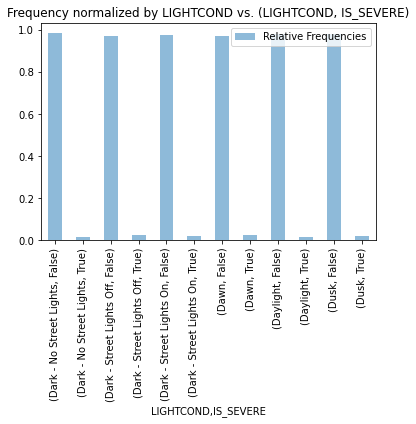

In [60]:
ax = df_frequencies_by_lightcond.plot.bar(alpha=.5, title='Frequency normalized by LIGHTCOND vs. (LIGHTCOND, IS_SEVERE)')

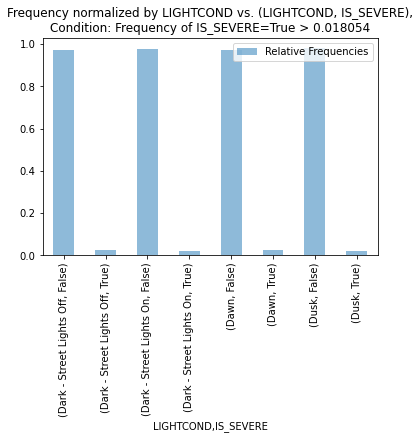

In [61]:
ax = df_frequencies_by_lightcond[df_frequencies_by_lightcond.xs(True, level=1, axis=0) > severity_frequency_cutoff].dropna().plot.bar(alpha=.5,\
    title='Frequency normalized by LIGHTCOND vs. (LIGHTCOND, IS_SEVERE),\nCondition: Frequency of IS_SEVERE=True > %f' %
    (severity_frequency_cutoff))

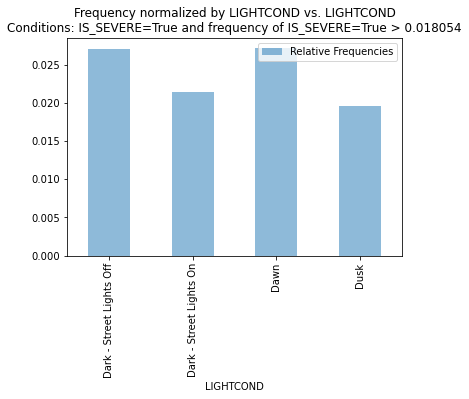

In [62]:
ax = df_frequencies_by_lightcond[\
    df_frequencies_by_lightcond.xs(True, level=1, axis=0) > severity_frequency_cutoff]\
    .dropna().xs(True, level=1, axis=0).plot.bar(alpha=.5,\
    title='Frequency normalized by LIGHTCOND vs. LIGHTCOND\nConditions: IS_SEVERE=True and frequency of IS_SEVERE=True > %f' %\
    (severity_frequency_cutoff))

In [63]:
print_elapsed_time(notebook_start_time)

Elapsed time is 36.695596111007035 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into two DataFrames, one for each value of the IS_SEVERE.

In [64]:
print('IS_SEVERE relative frequencies:')
print(df_categorical['IS_SEVERE'].value_counts(normalize=True, dropna=False))

IS_SEVERE relative frequencies:
False   0.981946146
True    0.018053854
Name: IS_SEVERE, Length: 2, dtype: float64


In [65]:
print("IS_SEVERE value counts:")
print(df_categorical['IS_SEVERE'].value_counts(normalize=False, dropna=False))

IS_SEVERE value counts:
False    146635
True       2696
Name: IS_SEVERE, Length: 2, dtype: int64


In [66]:
df_class_major_severity = df_categorical[df_categorical['IS_SEVERE']]
df_class_minor_severity = df_categorical[~df_categorical['IS_SEVERE']]

In [67]:
type(df_class_major_severity)

pandas.core.frame.DataFrame

In [68]:
df_class_major_severity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2696 entries, 116 to 221277
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   IS_SEVERE      2696 non-null   bool    
 1   COLLISIONTYPE  2696 non-null   category
 2   PEDCOUNT       2696 non-null   int64   
 3   PEDCYLCOUNT    2696 non-null   int64   
 4   WEATHER        2696 non-null   category
 5   ROADCOND       2696 non-null   category
 6   LIGHTCOND      2696 non-null   category
dtypes: bool(1), category(4), int64(2)
memory usage: 77.7 KB


In [69]:
type(df_class_minor_severity)

pandas.core.frame.DataFrame

In [70]:
df_class_minor_severity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146635 entries, 0 to 221388
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   IS_SEVERE      146635 non-null  bool    
 1   COLLISIONTYPE  146635 non-null  category
 2   PEDCOUNT       146635 non-null  int64   
 3   PEDCYLCOUNT    146635 non-null  int64   
 4   WEATHER        146635 non-null  category
 5   ROADCOND       146635 non-null  category
 6   LIGHTCOND      146635 non-null  category
dtypes: bool(1), category(4), int64(2)
memory usage: 4.1 MB


In [71]:
print("IS_SEVERE relative frequencies:")
print(df_class_major_severity["IS_SEVERE"].value_counts(normalize=False, dropna=False))

IS_SEVERE relative frequencies:
True    2696
Name: IS_SEVERE, Length: 1, dtype: int64


In [72]:
print("IS_SEVERE relative frequencies:")
print(df_class_minor_severity["IS_SEVERE"].value_counts(normalize=False, dropna=False))

IS_SEVERE relative frequencies:
False    146635
Name: IS_SEVERE, Length: 1, dtype: int64


In [73]:
# Store and print the size of the all classes.
class_major_severity_size = len(df_class_major_severity)
class_minor_severity_size = len(df_class_minor_severity)
print('class_major_severity_size =', class_major_severity_size)
print('class_minor_severity_size =', class_minor_severity_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_major_severity)
print('minority_class_size =', minority_class_size)

class_major_severity_size = 2696
class_minor_severity_size = 146635

minority_class_size = 2696


In [74]:
print_elapsed_time(notebook_start_time)

Elapsed time is 38.12108069699025 seconds.


<h2 id='sample_size_class_3'>Sample the Accident Severity Classes Equally to Create a Balanced Training Set<\h2>

In [75]:
# Number of folds for cross-validation
number_of_folds = number_of_folds
print('number_of_folds = %d' % (number_of_folds))

number_of_folds = 5


In [76]:
# This parameter determines what fraction of the data is reserved for testing.
# It must be between 0 and 1, exclusive, i.e. 0 < test_size_ratio < 1.
test_size_ratio = test_size_ratio
print('test_size_ratio = %f' % (test_size_ratio))

# Using train/test splits, set aside part of the data for testing.
df_class_minor_severity_train_pre_sampling, df_class_minor_severity_test =\
    train_test_split(df_class_minor_severity, test_size=test_size_ratio, random_state=seed)

df_class_major_severity_train_pre_sampling, df_class_major_severity_test =\
    train_test_split(df_class_major_severity, test_size=test_size_ratio, random_state=seed)

test_size_ratio = 0.200000


In [77]:
# Build a balanced training set by sampling the imbalanced training data equally by class:

sampling_ratio = sampling_ratio
print('sampling_ratio = %f' % (sampling_ratio))

# Set the boolean <replace> parameter of the sample method based on the sampling ratio.
# If the sampling_ratio > 1, sample with replacement.
# Otherwise, sample without replacement.
sample_with_replacement = bool(sampling_ratio > 1)

# Print the value of the replace parameter before passing it to the sample method.
print('Sample class major severity with replacement: %s' % (sample_with_replacement))

# Sample the minority class's training set based on the sampling parameter and store the sample for later concatenation.
df_class_major_severity_train = df_class_major_severity_train_pre_sampling.sample(frac=sampling_ratio,\
                                                                                  replace=sample_with_replacement,\
                                                                                  axis='index',\
                                                                                  random_state=seed)

# Store the size of the minority class's training set.
df_class_major_severity_train_size = df_class_major_severity_train.shape[0]

# Take a sample of the other class's pre-sampling training data,
# where the sample size taken is equal to the size of the minority class's training set.
# If the sample size to be taken exceeds the number of samples in available, sample with replacement.

# Sampling for class minor_severity
sample_with_replacement = bool(df_class_major_severity_train_size > df_class_minor_severity_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class minor severity with replacement: %s' % (sample_with_replacement))
df_class_minor_severity_train = df_class_minor_severity_train_pre_sampling.sample(n=df_class_major_severity_train_size,\
                                                                                   replace=sample_with_replacement, axis='index',\
                                                                                   random_state=seed)

sampling_ratio = 20.000000
Sample class major severity with replacement: True
Sample class minor severity with replacement: False


<h2>Generate a Balanced Training Set and an Unbalanced Test Set</h2>

In [78]:
# Make a balanced, unshuffled training set by concatenating the equal sized samples of the training sets for each class.
df_train_balanced_not_shuffled = pd.concat([df_class_minor_severity_train, df_class_major_severity_train], axis='index')

# Make a not necessarily balanced testing set by concatenating the testing sets for each class.
df_test_not_shuffled = pd.concat([df_class_minor_severity_test, df_class_major_severity_test], axis='index')

In [79]:
# Shuffle the training set and store it for tuning hyper-parameters and for cross-validation.
df_train = shuffle(df_train_balanced_not_shuffled, random_state=seed)

# Shuffle the unbalanced DataFrame and store it for validation and for comparing the models.
df_test = shuffle(df_test_not_shuffled, random_state=seed)

In [80]:
# Verify the training DataFrame is balanced.
print("IS_SEVERE relative frequencies:")
print(df_train["IS_SEVERE"].value_counts(normalize=False, dropna=False))

IS_SEVERE relative frequencies:
True     43120
False    43120
Name: IS_SEVERE, Length: 2, dtype: int64


In [81]:
# Verify the new DataFrame is balanced.
print("IS_SEVERE relative frequencies:")
print(df_train["IS_SEVERE"].value_counts(normalize=True, dropna=False))

IS_SEVERE relative frequencies:
True    0.500000000
False   0.500000000
Name: IS_SEVERE, Length: 2, dtype: float64


Let's define a feature set for the training data represented by a DataFrame. 

In [82]:
# Define a data frame to store the features for the training data.
df_features = df_train.drop(columns=['IS_SEVERE'], inplace=False)

In [83]:
# Display information about the features DataFrame.
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86240 entries, 157168 to 160265
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   COLLISIONTYPE  86240 non-null  category
 1   PEDCOUNT       86240 non-null  int64   
 2   PEDCYLCOUNT    86240 non-null  int64   
 3   WEATHER        86240 non-null  category
 4   ROADCOND       86240 non-null  category
 5   LIGHTCOND      86240 non-null  category
dtypes: category(4), int64(2)
memory usage: 2.3 MB


The boolean array y represents the target variable IS_SEVERE for the training data.

In [84]:
# Convert the training data target into a numpy array.
y = df_train['IS_SEVERE'].to_numpy()

In [85]:
print_elapsed_time(notebook_start_time)

Elapsed time is 39.654840041010175 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
The features are stored in sparse matrix format.

In [86]:
# Create a OneHotEncoder and fit it to the features.
# The fit is performed on the data set before the any test/train splits.
# The data will be encoded as a sparse matrix, the default behavior.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True, handle_unknown='error')
encoder.fit(df_categorical.drop(columns=['IS_SEVERE'], inplace=False))
X = encoder.transform(df_features)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.get_feature_names())

Fitting OneHotEncoder to training data...
Completed in 0.5389317590161227 seconds.
['x0_Angles' 'x0_Cycles' 'x0_Head On' 'x0_Left Turn' 'x0_Parked Car'
 'x0_Pedestrian' 'x0_Rear Ended' 'x0_Right Turn' 'x0_Sideswipe' 'x1_0'
 'x1_1' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x2_0' 'x2_1' 'x2_2'
 'x3_Blowing Sand/Dirt' 'x3_Clear' 'x3_Fog/Smog/Smoke' 'x3_Overcast'
 'x3_Partly Cloudy' 'x3_Raining' 'x3_Severe Crosswind'
 'x3_Sleet/Hail/Freezing Rain' 'x3_Snowing' 'x4_Dry' 'x4_Ice' 'x4_Oil'
 'x4_Sand/Mud/Dirt' 'x4_Snow/Slush' 'x4_Standing Water' 'x4_Wet'
 'x5_Dark - No Street Lights' 'x5_Dark - Street Lights Off'
 'x5_Dark - Street Lights On' 'x5_Dawn' 'x5_Daylight' 'x5_Dusk']


The sparse matrix X represents the one-hot encoded feature set for the training data.

In [87]:
# Display the type for the training data feature set.
type(X)

scipy.sparse.csr.csr_matrix

In [88]:
# Display the shape of the training data feature set.
X.shape

(86240, 41)

In [89]:
# Display the type for the training data target array.
type(y)

numpy.ndarray

In [90]:
# Display the shape of the training data target array.
y.shape

(86240,)

In [91]:
print_elapsed_time(notebook_start_time)

Elapsed time is 40.79940111399628 seconds.


In [92]:
#df_categorical.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29867 entries, 64587 to 116702
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   IS_SEVERE      29867 non-null  bool    
 1   COLLISIONTYPE  29867 non-null  category
 2   PEDCOUNT       29867 non-null  int64   
 3   PEDCYLCOUNT    29867 non-null  int64   
 4   WEATHER        29867 non-null  category
 5   ROADCOND       29867 non-null  category
 6   LIGHTCOND      29867 non-null  category
dtypes: bool(1), category(4), int64(2)
memory usage: 847.2 KB


In [93]:
# Print the relative frequencies for the validation DataFrame.
print("IS_SEVERE relative frequencies:")
print(df_test['IS_SEVERE'].value_counts(normalize=False, dropna=False))

IS_SEVERE relative frequencies:
False    29327
True       540
Name: IS_SEVERE, Length: 2, dtype: int64


In [94]:
# Print the relative frequencies for the validation DataFrame.
print("IS_SEVERE relative frequencies:")
print(df_test['IS_SEVERE'].value_counts(normalize=True, dropna=False))

IS_SEVERE relative frequencies:
False   0.981919845
True    0.018080155
Name: IS_SEVERE, Length: 2, dtype: float64


In [95]:
# Encode the test data features using the same instance of the OneHotEncoder that was fitted on the training data features.
start_time = default_timer()
print('Transforming features using OneHotEncoder...')
X_test = df_test.drop(columns=['IS_SEVERE'], inplace=False)
X_test = encoder.transform(X_test)
print("Encoding completed in", elapsed_time(start_time), "seconds.")

Transforming features using OneHotEncoder...
Encoding completed in 0.15871305897599086 seconds.


In [96]:
y_test = df_test['IS_SEVERE'].to_numpy()

In [97]:
X_test.shape

(29867, 41)

In [98]:
y_test.shape

(29867,)

In [99]:
print_elapsed_time(notebook_start_time)

Elapsed time is 41.888419148977846 seconds.


<h2 id="logistic_regression">Build and Test a Logistic Regression Model<\h2>

Classification Report for Logistic Regression on Unbalanced Test Data

              precision    recall  f1-score   support

       Major   0.067868  0.655556  0.123002       540
       Minor   0.992455  0.834214  0.906480     29327

    accuracy                       0.830984     29867
   macro avg   0.530161  0.744885  0.514741     29867
weighted avg   0.975738  0.830984  0.892315     29867



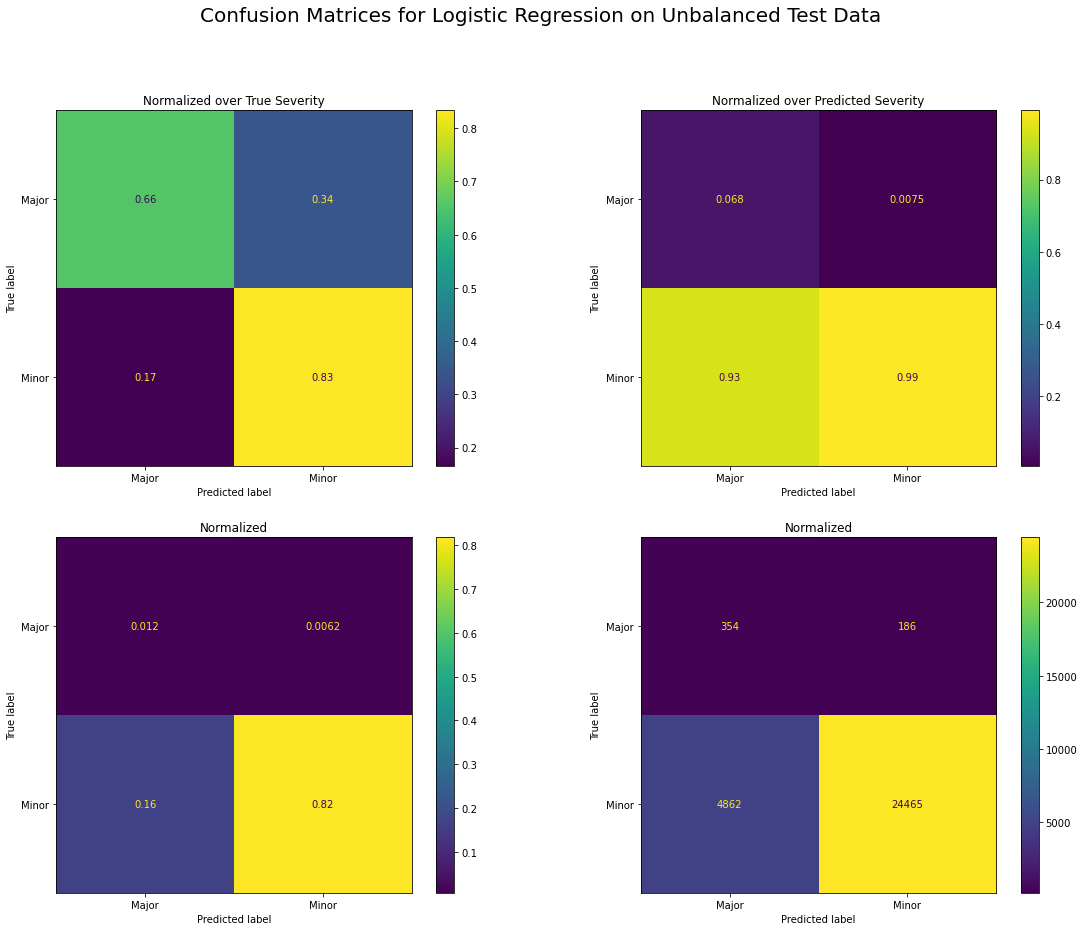


Logistic Regression Classification Report and Confusion Matrices generated in 20.213510 seconds.


In [100]:
t0 = default_timer()

# Make a pipline.
logistic_regression_pipe = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(solver='saga', random_state=seed), verbose=False)

# Fit the model to the balanced training data.
logistic_regression_pipe.fit(X, y)

# Use the fitted model to generate predictions based on test data.
y_pred = logistic_regression_pipe.predict(X_test)

# Set display labels.
labels = [True, False]
target_names = ['Major', 'Minor']
display_labels = target_names

# Display the classification report for Logistic Regression model applied to unbalanced test data.
logistic_regression_report = classification_report(y_test, y_pred, labels=labels, target_names=target_names, digits=6, output_dict=True)
print('Classification Report for Logistic Regression on Unbalanced Test Data')
print()
print(classification_report(y_test, y_pred, labels=labels, target_names=target_names, digits=6))


# Display the confusion matrices based on the unbalanced test data.
# Create a figure.
fig = plt.figure(figsize=(6.4 * 3, 4.8 * 3))
fig.suptitle('Confusion Matrices for Logistic Regression on Unbalanced Test Data', fontsize=20)
    
ax = plt.subplot(2, 2, 1)
ax.set_title('Normalized over True Severity', fontsize=12)
plot_confusion_matrix(logistic_regression_pipe, X_test, y_test, labels=labels, display_labels=display_labels, normalize='true', ax=ax)
    
ax = plt.subplot(2, 2, 2)
ax.set_title('Normalized over Predicted Severity', fontsize=12)
plot_confusion_matrix(logistic_regression_pipe, X_test, y_test, labels=labels, display_labels=display_labels, normalize='pred', ax=ax)
    
ax = plt.subplot(2, 2, 3)
ax.set_title('Normalized', fontsize=12)
plot_confusion_matrix(logistic_regression_pipe, X_test, y_test, labels=labels, display_labels=display_labels, normalize='all', ax=ax)

ax = plt.subplot(2, 2, 4)
ax.set_title('Normalized', fontsize=12)
plot_confusion_matrix(logistic_regression_pipe, X_test, y_test, labels=labels, display_labels=display_labels, normalize=None, ax=ax)

plt.show()

print()
print('Logistic Regression Classification Report and Confusion Matrices generated in %f seconds.' % elapsed_time(t0))

In [101]:
print_elapsed_time(notebook_start_time)

Elapsed time is 62.23954829399008 seconds.


<h2 id="support_vector_machine">Build and Test a Support Vector Machine<\h2>

Classification Report for Support Vector Machine on Unbalanced Test Data

              precision    recall  f1-score   support

       Major   0.066126  0.664815  0.120288       540
       Minor   0.992594  0.827122  0.902334     29327

    accuracy                       0.824187     29867
   macro avg   0.529360  0.745968  0.511311     29867
weighted avg   0.975843  0.824187  0.888195     29867



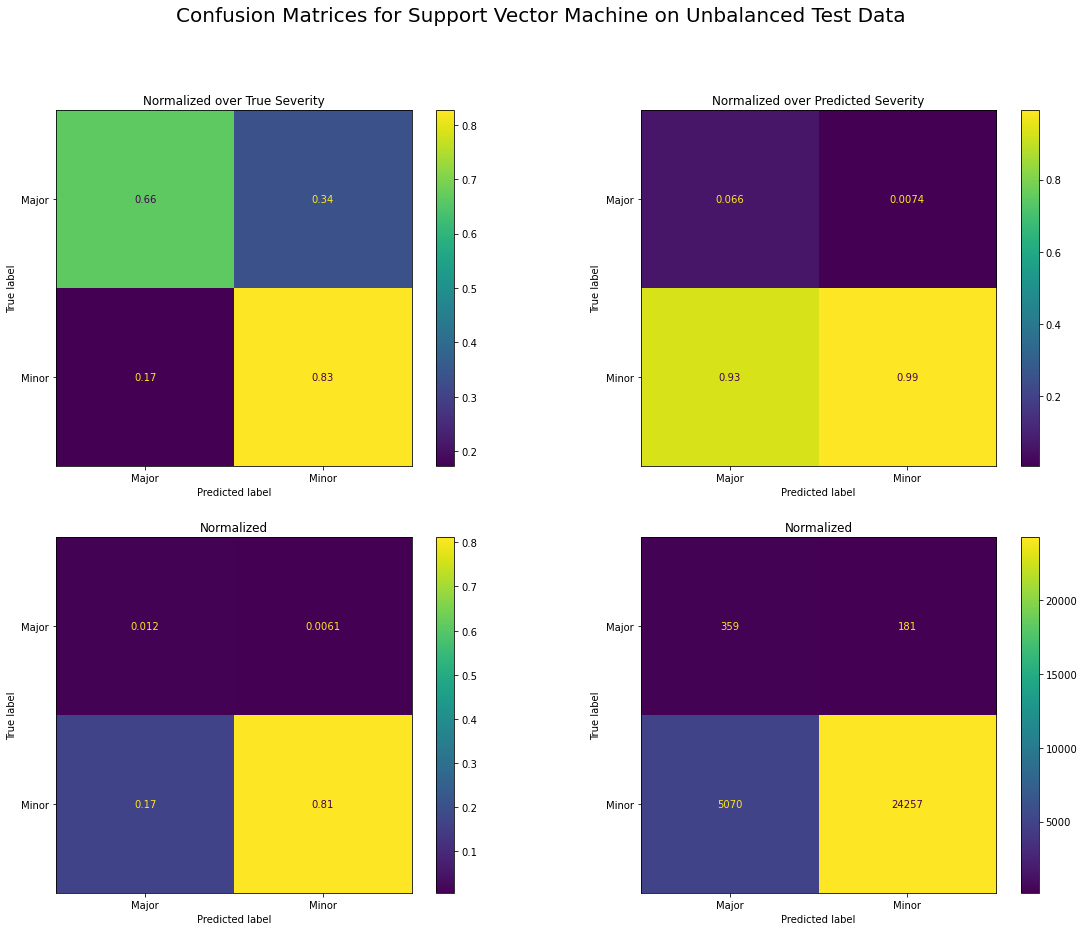


Support Vector Machine Classification Report and Confusion Matrices generated in 4.387816 seconds.


In [102]:
t0 = default_timer()

# Make a pipline.
support_vector_machine_pipe = make_pipeline(StandardScaler(with_mean=False), LinearSVC(dual=False, random_state=seed), verbose=False)

# Fit the model to the balanced training data.
support_vector_machine_pipe.fit(X, y)

# Use the fitted model to generate predictions based on test data.
y_pred = support_vector_machine_pipe.predict(X_test)

# Set display labels.
labels = [True, False]
target_names = ['Major', 'Minor']
display_labels = target_names


# Store and display the classification report for Support Vector Machine model applied to unbalanced test data.
support_vector_machine_report = classification_report(y_test, y_pred, labels=labels, target_names=target_names, digits=6, output_dict=True)
print('Classification Report for Support Vector Machine on Unbalanced Test Data')
print()
print(classification_report(y_test, y_pred, labels=labels, target_names=target_names, digits=6))

# Display the confusion matrices based on the unbalanced test data.
# Create a figure.
fig = plt.figure(figsize=(6.4 * 3, 4.8 * 3))
fig.suptitle('Confusion Matrices for Support Vector Machine on Unbalanced Test Data', fontsize=20)
    
ax = plt.subplot(2, 2, 1)
ax.set_title('Normalized over True Severity', fontsize=12)
plot_confusion_matrix(support_vector_machine_pipe, X_test, y_test, labels=labels, display_labels=display_labels, normalize='true', ax=ax)
    
ax = plt.subplot(2, 2, 2)
ax.set_title('Normalized over Predicted Severity', fontsize=12)
plot_confusion_matrix(support_vector_machine_pipe, X_test, y_test, labels=labels, display_labels=display_labels, normalize='pred', ax=ax)
    
ax = plt.subplot(2, 2, 3)
ax.set_title('Normalized', fontsize=12)
plot_confusion_matrix(support_vector_machine_pipe, X_test, y_test, labels=labels, display_labels=display_labels, normalize='all', ax=ax)

ax = plt.subplot(2, 2, 4)
ax.set_title('Normalized', fontsize=12)
plot_confusion_matrix(support_vector_machine_pipe, X_test, y_test, labels=labels, display_labels=display_labels, normalize=None, ax=ax)

plt.show()

print()
print('Support Vector Machine Classification Report and Confusion Matrices generated in %f seconds.' % elapsed_time(t0))

In [103]:
print_elapsed_time(notebook_start_time)

Elapsed time is 66.7945178039954 seconds.


<h2 id="knn_classifier">Building a k-Nearest Neighbors Classifier<\h2>

In [104]:
t0 = default_timer()

# Set the maximum number of neighbors based on number of training samples in each folds to prevent ValueError.
# Also, ensure number of neighbors is always an odd integer to avoid ties, using '2 * (N // 2) - 1' technique.
neighbors_upper_bound = neighbors_upper_bound # Set by user based on system resources.
maximum_number_of_neighbors = \
    min(2 * (neighbors_upper_bound // 2) - 1, (np.int(2 * ((X.shape[0] / number_of_folds) // 2) - 1 )))
print('maximum_number_of_neighbors = %d' % (maximum_number_of_neighbors))

# Make a pipeline.
k_neighbors_pipeline = make_pipeline(StandardScaler(with_mean=False), KNeighborsClassifier(n_jobs=-1), verbose=False)

# Use only odd numbers of neighbors to avoid ties.
# Number of neighbors range starts high and ends low, allowing user to  monitor kernel messages for possible local maxima in score.
grid_parameters = {'kneighborsclassifier__n_neighbors': range(maximum_number_of_neighbors, 1, -2)}
scoring = ['recall_weighted']
grid_search_cv = GridSearchCV(k_neighbors_pipeline, param_grid=grid_parameters, scoring=scoring, n_jobs=-1, refit='recall_weighted',\
                              cv=number_of_folds, verbose=50, error_score='raise', return_train_score=False)

grid_search_cv.fit(X, y)

print()
print('Completed grid search in %f seconds' % (elapsed_time(t0)))

maximum_number_of_neighbors = 49
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 45.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 54.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 63.1min
[Parallel(n_jobs=-1)]: 

In [105]:
# Store and print the best KNeighborsClassifier from GridSearchCV.
k_neighbors_clf = grid_search_cv.best_estimator_
print('Best KNeighborsClassifier parameters:')
for key in k_neighbors_clf.get_params().keys():
    print(key, ':', k_neighbors_clf.get_params()[key])

Best KNeighborsClassifier parameters:
memory : None
steps : [('standardscaler', StandardScaler(with_mean=False)), ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=25))]
verbose : False
standardscaler : StandardScaler(with_mean=False)
kneighborsclassifier : KNeighborsClassifier(n_jobs=-1, n_neighbors=25)
standardscaler__copy : True
standardscaler__with_mean : False
standardscaler__with_std : True
kneighborsclassifier__algorithm : auto
kneighborsclassifier__leaf_size : 30
kneighborsclassifier__metric : minkowski
kneighborsclassifier__metric_params : None
kneighborsclassifier__n_jobs : -1
kneighborsclassifier__n_neighbors : 25
kneighborsclassifier__p : 2
kneighborsclassifier__weights : uniform


Classification Report for k-Nearest Neighbors on Unbalanced Test Data

              precision    recall  f1-score   support

       Major   0.072768  0.603704  0.129880       540
       Minor   0.991570  0.858356  0.920167     29327

    accuracy                       0.853752     29867
   macro avg   0.532169  0.731030  0.525024     29867
weighted avg   0.974958  0.853752  0.905878     29867



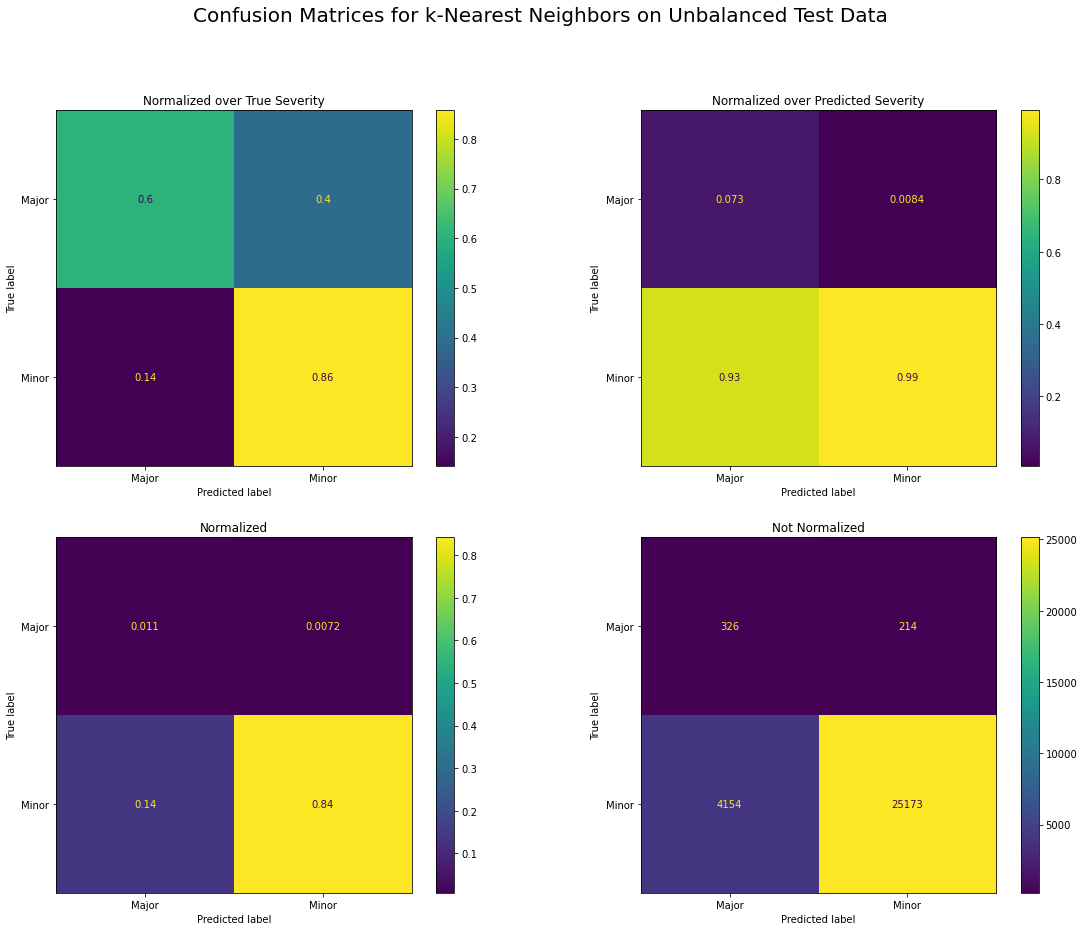


k-Nearest Neighbors Classification Report and Confusion Matrices generated in 3030.576452 seconds.


In [106]:
t0 = default_timer()

# Use the fitted model to generate predictions based on test data.
y_pred = k_neighbors_clf.predict(X_test)

# Set display labels.
labels = [True, False]
target_names = ['Major', 'Minor']
display_labels = target_names

# Store and display the classification report for k-Nearest Neighbors model applied to unbalanced test data.
k_neighbors_report = classification_report(y_test, y_pred, labels=labels, target_names=target_names, digits=6, output_dict=True)
print('Classification Report for k-Nearest Neighbors on Unbalanced Test Data')
print()
print(classification_report(y_test, y_pred, labels=labels, target_names=target_names, digits=6))

# Display the confusion matrices based on the unbalanced test data.
# Create a figure.
fig = plt.figure(figsize=(6.4 * 3, 4.8 * 3))
fig.suptitle('Confusion Matrices for k-Nearest Neighbors on Unbalanced Test Data', fontsize=20)
    
ax = plt.subplot(2, 2, 1)
ax.set_title('Normalized over True Severity', fontsize=12)
plot_confusion_matrix(k_neighbors_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize='true', ax=ax)
    
ax = plt.subplot(2, 2, 2)
ax.set_title('Normalized over Predicted Severity', fontsize=12)
plot_confusion_matrix(k_neighbors_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize='pred', ax=ax)
    
ax = plt.subplot(2, 2, 3)
ax.set_title('Normalized', fontsize=12)
plot_confusion_matrix(k_neighbors_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize='all', ax=ax)

ax = plt.subplot(2, 2, 4)
ax.set_title('Not Normalized', fontsize=12)
plot_confusion_matrix(k_neighbors_clf, X_test, y_test, labels=labels, display_labels=display_labels, normalize=None, ax=ax)

plt.show()

print()
print('k-Nearest Neighbors Classification Report and Confusion Matrices generated in %f seconds.' % elapsed_time(t0))

In [107]:
print_elapsed_time(notebook_start_time)

Elapsed time is 34418.432502473006 seconds.


<h2 id="decision_tree_classifier">Building and Test a Decision Tree Classifier<\h2>

Classification Report for Decision Tree on Unbalanced Test Data

              precision    recall  f1-score   support

       Major   0.059692  0.666667  0.109572       540
       Minor   0.992448  0.806629  0.889942     29327

    accuracy                       0.804098     29867
   macro avg   0.526070  0.736648  0.499757     29867
weighted avg   0.975584  0.804098  0.875833     29867



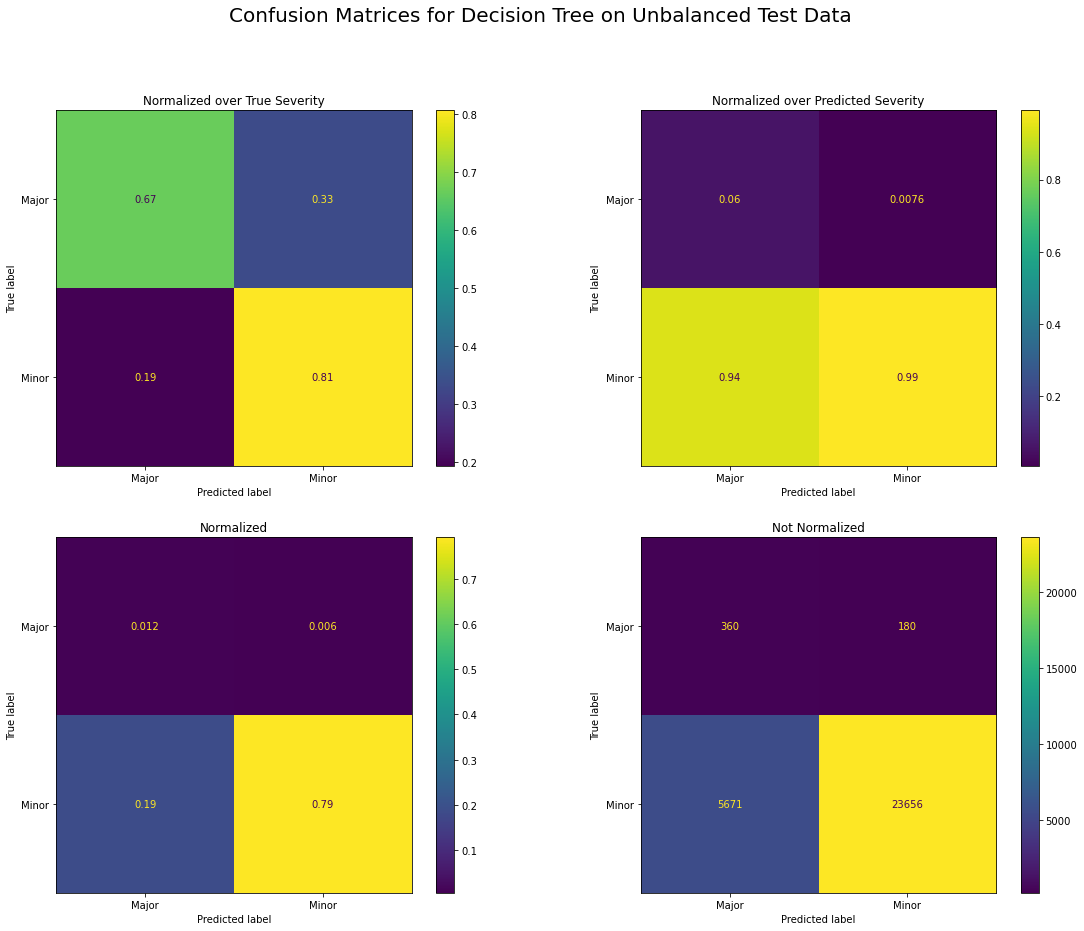


Decision Tree Classification Report and Confusion Matrices generated in 5.283941 seconds.


In [108]:
t0 = default_timer()

# Make a pipline.
decision_tree_pipe = make_pipeline(StandardScaler(with_mean=False), DecisionTreeClassifier(random_state=seed), verbose=False)

# Fit the model to the balanced training data.
decision_tree_pipe.fit(X, y)

# Use the fitted model to generate predictions based on test data.
y_pred = decision_tree_pipe.predict(X_test)

# Set display labels.
labels = [True, False]
target_names = ['Major', 'Minor']
display_labels = target_names

# Store and display the classification report for Decision Tree model applied to unbalanced test data.
decision_tree_report = classification_report(y_test, y_pred, labels=labels, target_names=target_names, digits=6, output_dict=True)
print('Classification Report for Decision Tree on Unbalanced Test Data')
print()
print(classification_report(y_test, y_pred, labels=labels, target_names=target_names, digits=6))

# Display the confusion matrices based on the unbalanced test data.
# Create a figure.
fig = plt.figure(figsize=(6.4 * 3, 4.8 * 3))
fig.suptitle('Confusion Matrices for Decision Tree on Unbalanced Test Data', fontsize=20)
    
ax = plt.subplot(2, 2, 1)
ax.set_title('Normalized over True Severity', fontsize=12)
plot_confusion_matrix(decision_tree_pipe, X_test, y_test, labels=labels, display_labels=display_labels, normalize='true', ax=ax)
    
ax = plt.subplot(2, 2, 2)
ax.set_title('Normalized over Predicted Severity', fontsize=12)
plot_confusion_matrix(decision_tree_pipe, X_test, y_test, labels=labels, display_labels=display_labels, normalize='pred', ax=ax)
    
ax = plt.subplot(2, 2, 3)
ax.set_title('Normalized', fontsize=12)
plot_confusion_matrix(decision_tree_pipe, X_test, y_test, labels=labels, display_labels=display_labels, normalize='all', ax=ax)

ax = plt.subplot(2, 2, 4)
ax.set_title('Not Normalized', fontsize=12)
plot_confusion_matrix(decision_tree_pipe, X_test, y_test, labels=labels, display_labels=display_labels, normalize=None, ax=ax)

plt.show()

print()
print('Decision Tree Classification Report and Confusion Matrices generated in %f seconds.' % elapsed_time(t0))

In [109]:
print_elapsed_time(notebook_start_time)

Elapsed time is 34423.875976651965 seconds.


## Compare the Models

In [110]:
# Define a list of names for the models in this report.
model_names_list = ['Logistic Regression', 'Support Vector Machine', 'k-Nearest Neighbors', 'Decision Tree']

In [111]:
# Define a dictionary mapping each model name to its corresponding classifier.
model_classifiers = {'Logistic Regression': logistic_regression_pipe,\
                         'Support Vector Machine': support_vector_machine_pipe,\
                         'k-Nearest Neighbors': k_neighbors_clf,\
                         'Decision Tree': decision_tree_pipe}

In [112]:
# Define a dictionary mapping each model name to its corresponding classification report.
model_report_dict = {'Logistic Regression': logistic_regression_report,\
                         'Support Vector Machine': support_vector_machine_report,\
                         'k-Nearest Neighbors': k_neighbors_report,\
                         'Decision Tree': decision_tree_report}

In [113]:
model_performance_df = pd.DataFrame()

# This dict will serve as a mapper to rename the generic indices to the names of the models.
new_index = dict()
for index, name in enumerate(model_names_list):
  #print(name, ':', model_report_dict[name]['weighted avg'])
  new_index[index] = name
  model_performance_df = model_performance_df.append(model_report_dict[name]['weighted avg'], ignore_index=True)

model_performance_df.rename(index=new_index, inplace=True)
model_performance_df = model_performance_df[['recall', 'precision', 'f1-score']]

In [118]:
print("Models Sorted by Weighted Recall Score:")
model_performance_df.sort_values(by='recall', axis='index', ascending=False, inplace=True)
model_performance_df

Models Sorted by Weighted Recall Score:


,recall,precision,f1-score
k-Nearest Neighbors,0.853751632,0.974958395,0.905878188
Logistic Regression,0.830984029,0.975737998,0.892315008
Support Vector Machine,0.824187230,0.975842832,0.888194718
Decision Tree,0.804098169,0.975584009,0.875833044


In [119]:
print("Models Sorted by Weighted Precision Score:")
model_performance_df.sort_values(by='precision', axis='index', ascending=False, inplace=True)
model_performance_df

Models Sorted by Weighted Precision Score:


,recall,precision,f1-score
Support Vector Machine,0.824187230,0.975842832,0.888194718
Logistic Regression,0.830984029,0.975737998,0.892315008
Decision Tree,0.804098169,0.975584009,0.875833044
k-Nearest Neighbors,0.853751632,0.974958395,0.905878188


In [120]:
print("Models Sorted By Weighted F-1 Score:")
model_performance_df.sort_values(by='f1-score', axis='index', ascending=False, inplace=True)
model_performance_df

Models Sorted By Weighted F-1 Score:


,recall,precision,f1-score
k-Nearest Neighbors,0.853751632,0.974958395,0.905878188
Logistic Regression,0.830984029,0.975737998,0.892315008
Support Vector Machine,0.824187230,0.975842832,0.888194718
Decision Tree,0.804098169,0.975584009,0.875833044


In [117]:
print_elapsed_time(notebook_start_time)

Elapsed time is 34425.01980011497 seconds.
